In [20]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pickle
import numpy as np
import os.path
from os import listdir

In [133]:
def plotdea(file, loss: bool = True, title = ""):
    if "pkl" not in file:
        file += ".pkl"
    if "out" not in file:
        file = "out/" + file
    with open(file,'rb') as savefile:
        save = pickle.load(savefile)
    print(save['args'])
    if "test" in save:
        print("Test accuracy: "+str(save['test']['accuracy']))
    log = save
    if loss:
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
        ax1.set_yscale('log')
        log['epochsteps'] = list(range(1,save['args'].epochs+1))
        for i in range(1, len(log['trainsteps'])):
            if log['trainsteps'][i] < log['trainsteps'][i-1]:
                for j in range(i, len(log['trainsteps'])):
                    log['trainsteps'][j] += 1
        ax1.plot(log['trainsteps'], log['train']['batchloss'])
        ax2.plot(log['epochsteps'], log['validation']['accuracy'])
        ax1.set_title('Training loss')
        maxacc = str(max(log['validation']['accuracy']))
        maxacc = maxacc[:min(len(maxacc), 6)]
        ax2.set_title('Validation accuracy (max: '+maxacc+')')
        ax1.set_xlabel('Epochs')
        ax2.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax2.set_ylabel('Accuracy')
        plt.savefig(file[:-4]+'loss')
    alphas = [[[] for _ in range(len(log['alphas'][0][0]))] for _ in range(len(log['alphas'][0]))]
    groups = []
    group = (1,2) if len(alphas[0]) == 7 else (0,2) if len(alphas[0]) == 4 else (1,4) 
    for i in range(group[0]+1):
        for j in range(group[1]+1):
            groups.append((i,j))
    groups.append("Skip")
    for i in range(len(log['alphas'])): #timesteps
        for j in range(len(log['alphas'][0])): #layers
            for k in range(len(log['alphas'][0][0])): #groups
                alphas[j][k].append(log['alphas'][i][j][k])
    if 'channels' in log:
        channels = log['channels']
    else:
        if len(alphas[0]) == 8:
            channels = [8*4 for _ in range(4)]+[8*8 for _ in range(4)]
        else:
            channels = [8*4 for _ in range(4)]+[8*8 for _ in range(4)]+ \
                          [8*12 for _ in range(4)]+[8*16 for _ in range(4)]
    cmap = plt.cm.get_cmap('viridis') 
    cmap2 = plt.cm.get_cmap('plasma')
    colors = []
    for g in groups:
        if g == "Skip":
            colors.append("dimgrey")
        elif g[0] == 0:
            colors.append(cmap((1.5*(1-g[1]/4)+0.6)/2.5))
        else:
            colors.append(cmap2((1.5*(1-g[1]/4)+0.6)/2.5))
    # _, axs = plt.subplots(int(np.ceil(len(alphas)/4)), 4, figsize=(16, len(alphas)), sharey=True)
    # for i in range(len(alphas)):
    #     for j in range(len(alphas[0])):
    #         axs[i//4][i%4].plot(list(range(51)), alphas[i][j], label=str(groups[j]), color=colors[j])
    #     axs[i//4][i%4].set_title('Layer '+str(i+1)+' Channels: '+str(channels[i]))
    # axs[0][0].legend()
    _, axs = plt.subplots(int(np.ceil(len(alphas)/4)), 4, figsize=(16, len(alphas)), sharey=True)
    for i in range(len(alphas)):
        alphasum = [1.0 for _ in range(51)]
        label = str(groups[0])
        label = label.replace('(0, 0)', '$C_1$')
        label = label.replace('(0, 1)', '$C_2$')
        label = label.replace('(0, 2)', '$C_4$')
        label = label.replace('(0, 3)', '$C_8$')
        label = label.replace('(0, 4)', '$C_{16}$')
        label = label.replace('(1, 0)', '$D_1$')
        label = label.replace('(1, 1)', '$D_2$')
        label = label.replace('(1, 2)', '$D_4$')
        label = label.replace('(1, 3)', '$D_8$')
        label = label.replace('(1, 4)', '$D_{16}$')
        axs[i//4][i%4].fill_between(list(range(51)), [alphasum[k] - alphas[i][0][k] for k in range(len(alphas[0][0]))], alphasum, label=label, color=colors[0])
        alphasum = [alphasum[k] - alphas[i][0][k] for k in range(len(alphas[0][0]))]
        for j in range(1,len(alphas[0])):
            label = str(groups[j])
            label = label.replace('(0, 0)', '$C_1$')
            label = label.replace('(0, 1)', '$C_2$')
            label = label.replace('(0, 2)', '$C_4$')
            label = label.replace('(0, 3)', '$C_8$')
            label = label.replace('(0, 4)', '$C_{16}$')
            label = label.replace('(1, 0)', '$D_1$')
            label = label.replace('(1, 1)', '$D_2$')
            label = label.replace('(1, 2)', '$D_4$')
            label = label.replace('(1, 3)', '$D_8$')
            label = label.replace('(1, 4)', '$D_{16}$')
            axs[i//4][i%4].fill_between(list(range(51)), [alphasum[k] - alphas[i][j][k] for k in range(len(alphas[0][0]))], alphasum, label=label, color=colors[j])
            alphasum = [alphasum[k] - alphas[i][j][k] for k in range(len(alphas[0][0]))]
        axs[i//4][i%4].set_title('Layer '+str(i+1)+' Channels: '+str(channels[i]))
    axs[0][0].legend()
    for i in range(len(axs)):
        for j in range(len(axs[0])):
            axs[i][j].set_xlim(0,50)
            axs[i][j].set_ylim(0,1)
    if len(title) > 0:
        plt.suptitle(title)
    plt.savefig(file[:-4]+'alphas')

def comparedea(files, labels = False):
    logs = [{} for _ in range(len(files))]
    if not labels:
        labels = ["" for _ in range(len(files))]
    for f_ind in range(len(files)):
        plotdea(files[f_ind], loss=False, title=labels[f_ind])
        file = files[f_ind]
        if "pkl" not in file:
            file += ".pkl"
        if "out" not in file:
            file = "out/" + file
        with open(file,'rb') as savefile:
            save = pickle.load(savefile)
        logs[f_ind] = save
        files[f_ind] = file
        if 'epochsteps' not in logs[f_ind]:
            logs[f_ind]['epochsteps'] = list(range(1,51))
        if 'trainsteps' not in logs[f_ind]:
            for i in range(1, len(logs[f_ind]['trainsteps'])):
                if logs[f_ind]['trainsteps'][i] < logs[f_ind]['trainsteps'][i-1]:
                    for j in range(i, len(logs[f_ind]['trainsteps'])):
                        logs[f_ind]['trainsteps'][j] += 1
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
    ax1.set_yscale('log')
    for i in range(len(logs)):
        maxacc = str(max(logs[i]['validation']['accuracy']))
        maxacc = maxacc[:min(len(maxacc), 6)]
        ax1.plot(logs[i]['trainsteps'], logs[i]['train']['batchloss'], label=labels[i], alpha=0.7)
        ax2.plot(logs[i]['epochsteps'], logs[i]['validation']['accuracy'], label=labels[i]+' (max: '+maxacc+')', alpha=0.7)
    ax1.set_title('Training loss')
    ax2.set_title('Validation accuracy')
    ax1.set_xlabel('Epochs')
    ax2.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.savefig(os.path.commonprefix(files)+'loss')

def plotavg(ax, x, ydata, label, alpha=1.0, color=None):
    #find average of list of lists
    ydata = np.array([np.array(y) for y in ydata])
    yavg = np.average(ydata, axis=0)
    ystd = np.std(ydata, axis=0)
    if color is None:
        ax.plot(x, yavg, label=label, alpha=alpha)
        ax.fill_between(x, yavg-ystd, yavg+ystd, alpha=0.2*alpha)
    else:
        ax.plot(x, yavg, color=color, alpha=alpha, label=label)
        ax.fill_between(x, yavg-ystd, yavg+ystd, alpha=0.2*alpha, color=color)


def plotfolder(folder):
    files = [[],[],[],[]]
    labels = ["","","",""]
    for file in os.listdir(folder):
        if "png" in file:
            continue
        if "bl" in file:
            if "C1" in file:
                files[2].append(folder+"/"+file)
                labels[2] = "$C_1$ Baseline"
            else:
                print(file)
                group = file.split("_")[2][2:]
                group = "$"+group[0]+"_"+group[1]+"$ Baseline"
                files[3].append(folder+"/"+file)
                labels[3] = group
        else:
            filename = folder+"/"+file
            if "pkl" not in filename:
                filename += ".pkl"
            if "out" not in filename:
                filename = "out/" + filename
            with open(filename,'rb') as savefile:
                save = pickle.load(savefile)
            if save['args'].equalize:
                index = 0
                label = "DEA-NAS (No Prior)"
            else:
                index = 1
                label = "DEA-NAS (Prior)"
            files[index].append(folder+"/"+file)
            labels[index] = label
    logs = [[{} for _ in range(len(files[i]))] for i in range(len(files))]
    results = [{} for _ in range(len(files))]
    for trial in range(len(files)):
        for f_ind in range(len(files[trial])):
            file = files[trial][f_ind]
            if "pkl" not in file:
                file += ".pkl"
            if "out" not in file:
                file = "out/" + file
            with open(file,'rb') as savefile:
                save = pickle.load(savefile)
            print(files[trial][f_ind])
            print(save["args"])
            #plotdea(files[trial][f_ind], loss=False, title=labels[trial]+" Seed: "+str(save["args"].seed))
            logs[trial][f_ind] = save
            files[trial][f_ind] = file
            if 'epochsteps' not in logs[trial][f_ind]:
                logs[trial][f_ind]['epochsteps'] = list(range(1,51))
            if 'trainsteps' not in logs[trial][f_ind]:
                for i in range(1, len(logs[trial][f_ind]['trainsteps'])):
                    if logs[trial][f_ind]['trainsteps'][i] < logs[trial][f_ind]['trainsteps'][i-1]:
                        for j in range(i, len(logs[trial][f_ind]['trainsteps'])):
                            logs[trial][f_ind]['trainsteps'][j] += 1
    for trial in range(len(files)):
        results[trial]["taccs"] = [logs[trial][i]['test']['accuracy'] for i in range(len(logs[trial]))]
        results[trial]["tlosses"] = [logs[trial][i]['train']['batchloss'] for i in range(len(logs[trial]))]
        results[trial]["vaccs"] = [logs[trial][i]['validation']['accuracy'] for i in range(len(logs[trial]))]
    _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8))
    ax1.set_yscale('log')
    colors = ["#0072B2", "#D55E00", "#009E73", "#CC79A7", "#F0E442", "#56B4E9"]
    for trial in range(len(logs)):
        #maxacc = str(max(logs[i]['validation']['accuracy']))
        #maxacc = maxacc[:min(len(maxacc), 6)]
        if len(logs[trial]) > 0:
            plotavg(ax1, logs[trial][0]['trainsteps'], results[trial]["tlosses"], labels[trial], color=colors[trial], alpha=0.7)
            plotavg(ax2, logs[trial][0]['epochsteps'], results[trial]["vaccs"], labels[trial], color=colors[trial])
    ax3.boxplot([np.array(results[trial]["taccs"]) for trial in range(len(logs))], labels=[labels[trial] for trial in range(len(logs))])
    ax2.set_ylim(0.7,1.0)
    ax1.set_title('Training loss')
    ax2.set_title('Validation accuracy')
    ax3.set_title('Test accuracy')
    ax1.set_xlabel('Epochs')
    ax2.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    ax3.set_ylabel('Accuracy')
    ax3.tick_params(axis='x', rotation=30)
    ax2.legend()
    plt.savefig(folder+'/results.png')
    for trial in range(len(logs)):
        alphas =[[[[] for _ in range(len(logs[trial][i]['alphas'][0][0]))] for _ in range(len(logs[trial][i]['alphas'][0]))] for i in range(len(logs[trial]))]
        groups = []
        group = (1,2) if len(alphas[0][0]) == 7 else (0,2) if len(alphas[0][0]) == 4 else (1,4) 
        for i in range(group[0]+1):
            for j in range(group[1]+1):
                groups.append((i,j))
        groups.append("Skip")
        for h in range(len(logs[trial])): #seeds
            for i in range(len(logs[trial][h]['alphas'])): #timesteps
                for j in range(len(logs[trial][h]['alphas'][0])): #layers
                    for k in range(len(logs[trial][h]['alphas'][0][0])): #groups
                        alphas[h][j][k].append(logs[trial][h]['alphas'][i][j][k])
        if 'channels' in logs[trial][0]:
            channels = logs[trial][0]['channels']
        else:
            if len(alphas[0][0]) == 8:
                channels = [8*4 for _ in range(4)]+[8*8 for _ in range(4)]
            else:
                channels = [8*4 for _ in range(4)]+[8*8 for _ in range(4)]+ \
                            [8*12 for _ in range(4)]+[8*16 for _ in range(4)]
        cmap = plt.cm.get_cmap('viridis') 
        cmap2 = plt.cm.get_cmap('plasma')
        colors = []
        for g in groups:
            if g == "Skip":
                colors.append("dimgrey")
            elif g[0] == 0:
                colors.append(cmap((1.5*(1-g[1]/4)+0.6)/2.5))
            else:
                colors.append(cmap2((1.5*(1-g[1]/4)+0.6)/2.5))
        # _, axs = plt.subplots(int(np.ceil(len(alphas)/4)), 4, figsize=(16, len(alphas)), sharey=True)
        # for i in range(len(alphas)):
        #     for j in range(len(alphas[0])):
        #         axs[i//4][i%4].plot(list(range(51)), alphas[i][j], label=str(groups[j]), color=colors[j])
        #     axs[i//4][i%4].set_title('Layer '+str(i+1)+' Channels: '+str(channels[i]))
        # axs[0][0].legend()
        _, axs = plt.subplots(len(alphas),len(alphas[0]), figsize=(len(alphas[0])*1.5, len(alphas)*1.8), sharey=True)
        for i in range(len(alphas)): #seeds
            for j in range(len(alphas[0])): #layers
                alphasum = [1.0 for _ in range(51)]
                label = str(groups[0])
                label = label.replace('(0, 0)', '$C_1$')
                label = label.replace('(0, 1)', '$C_2$')
                label = label.replace('(0, 2)', '$C_4$')
                label = label.replace('(0, 3)', '$C_8$')
                label = label.replace('(0, 4)', '$C_{16}$')
                label = label.replace('(1, 0)', '$D_1$')
                label = label.replace('(1, 1)', '$D_2$')
                label = label.replace('(1, 2)', '$D_4$')
                label = label.replace('(1, 3)', '$D_8$')
                label = label.replace('(1, 4)', '$D_{16}$')
                axs[i][j].fill_between(list(range(51)), [alphasum[k] - alphas[i][j][0][k] for k in range(len(alphas[0][0][0]))], alphasum, label=label, color=colors[0])
                alphasum = [alphasum[k] - alphas[i][j][0][k] for k in range(len(alphas[0][0][0]))]
                for l in range(1,len(alphas[0][0])): #groups
                    label = str(groups[l])
                    label = label.replace('(0, 0)', '$C_1$')
                    label = label.replace('(0, 1)', '$C_2$')
                    label = label.replace('(0, 2)', '$C_4$')
                    label = label.replace('(0, 3)', '$C_8$')
                    label = label.replace('(0, 4)', '$C_{16}$')
                    label = label.replace('(1, 0)', '$D_1$')
                    label = label.replace('(1, 1)', '$D_2$')
                    label = label.replace('(1, 2)', '$D_4$')
                    label = label.replace('(1, 3)', '$D_8$')
                    label = label.replace('(1, 4)', '$D_{16}$')
                    axs[i][j].fill_between(list(range(51)), [alphasum[k] - alphas[i][j][l][k] for k in range(len(alphas[0][0][0]))], alphasum, label=label, color=colors[l])
                    alphasum = [alphasum[k] - alphas[i][j][l][k] for k in range(len(alphas[0][0][0]))]
                if i == 0:
                    axs[i][j].set_title('Layer '+str(j+1))
            axs[i][0].set_ylabel('Trial '+str(i+1))
        axs[1][-1].legend(bbox_to_anchor = (2, 0.5))
        for i in range(len(axs)):
            for j in range(len(axs[0])):
                axs[i][j].set_xlim(0,50)
                axs[i][j].set_ylim(0,1)
        plt.subplots_adjust(#wspace=0.4, 
                    hspace=0.45)
        plt.suptitle(labels[trial])
        plt.savefig(folder+'/'+labels[trial]+'alphas.png')




logsdea_2_blD4_2022-09-13_10:51:21.pkl
logsdea_5_blD4_2022-09-13_12:23:29.pkl
logsdea_3_blD4_2022-09-13_11:05:44.pkl
logsdea_4_blD4_2022-09-13_12:07:14.pkl
logsdea_1_blD4_2022-09-13_09:47:55.pkl
out/olympe/deanas_mnist_wlr0.005_alr0.005_2022-09-13.09:47:11/logsdea_4_deaeq_2022-09-13_11:20:07.pkl
Namespace(epochs=50, weightlr=0.005, alphalr=0.005, hidden=64, basechannels=16, kernel=5, path=PosixPath('/tmpdir/maile'), equalize=True, baseline=False, task='mnist', seed=4, batch_size=-1, d16=False, c4=False, tune=False, test=True, folder='/deanas_mnist_wlr0.005_alr0.005_2022-09-13.09:47:11', indim=1, outdim=10, stages=2, pools=4)
out/olympe/deanas_mnist_wlr0.005_alr0.005_2022-09-13.09:47:11/logsdea_1_deaeq_2022-09-13_09:47:55.pkl
Namespace(epochs=50, weightlr=0.005, alphalr=0.005, hidden=64, basechannels=16, kernel=5, path=PosixPath('/tmpdir/maile'), equalize=True, baseline=False, task='mnist', seed=1, batch_size=-1, d16=False, c4=False, tune=False, test=True, folder='/deanas_mnist_wlr0.005

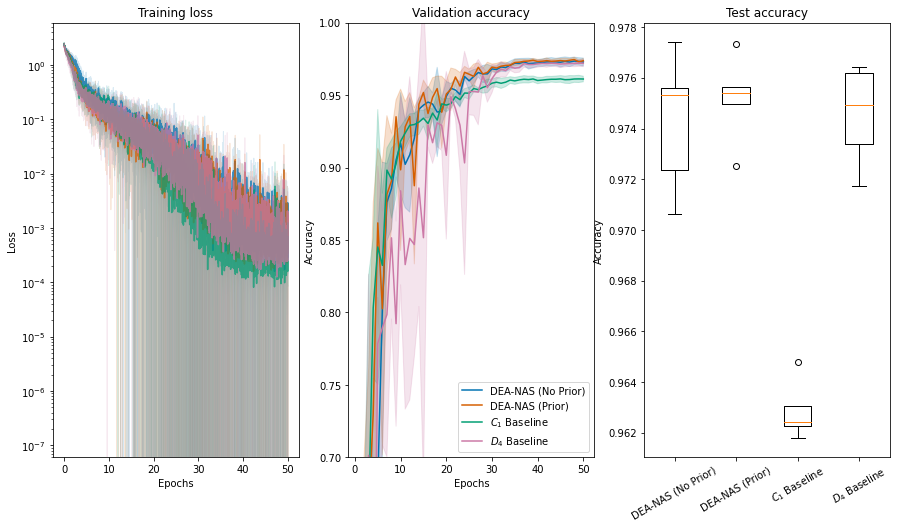

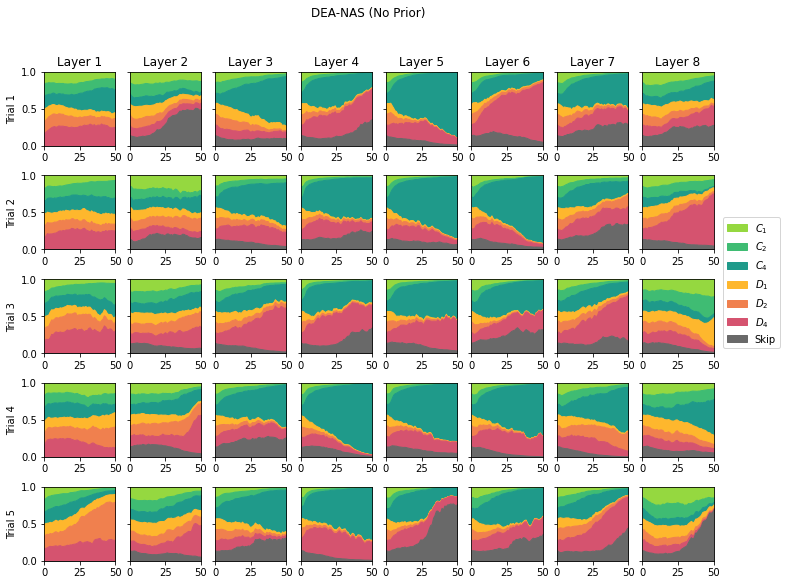

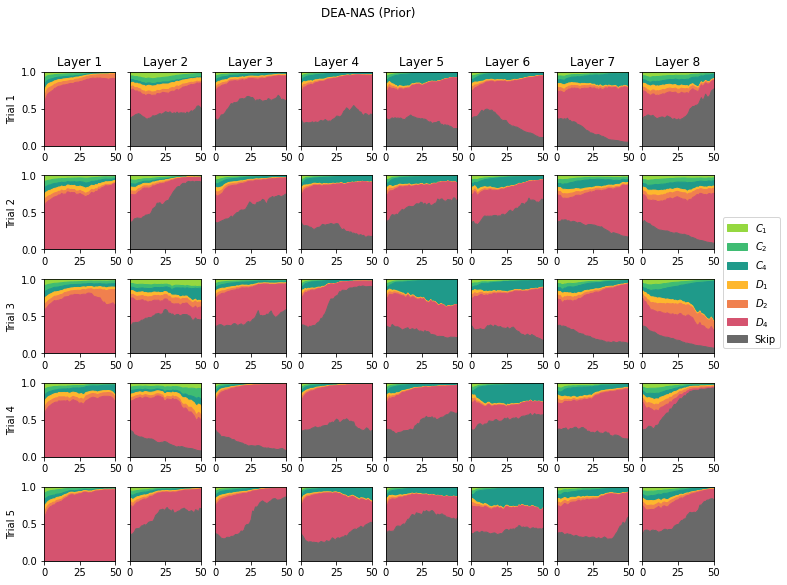

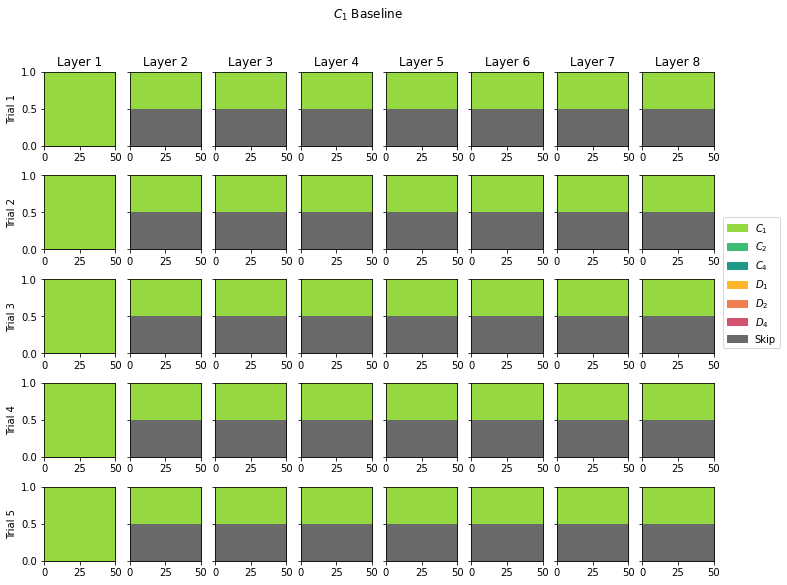

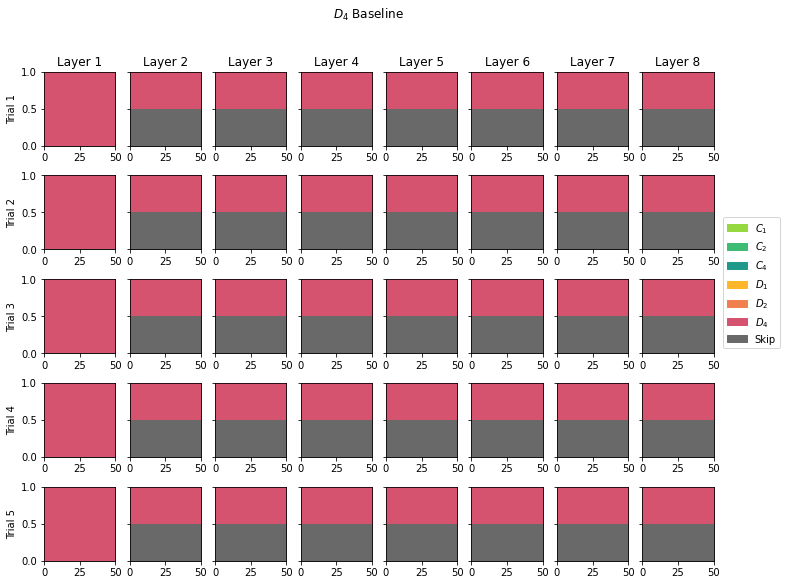

In [134]:
plotfolder("out/olympe/deanas_mnist_wlr0.005_alr0.005_2022-09-13.09:47:11")

logsdea_2_blD4_2022-09-13_10:51:21.pkl
logsdea_5_blD4_2022-09-13_12:23:29.pkl
logsdea_3_blD4_2022-09-13_11:05:44.pkl
logsdea_4_blD4_2022-09-13_12:07:14.pkl
logsdea_1_blD4_2022-09-13_09:47:55.pkl
out/olympe/deanas_mnist_wlr0.005_alr0.005_2022-09-13.09:47:11/logsdea_4_deaeq_2022-09-13_11:20:07.pkl
Namespace(epochs=50, weightlr=0.005, alphalr=0.005, hidden=64, basechannels=16, kernel=5, path=PosixPath('/tmpdir/maile'), equalize=True, baseline=False, task='mnist', seed=4, batch_size=-1, d16=False, c4=False, tune=False, test=True, folder='/deanas_mnist_wlr0.005_alr0.005_2022-09-13.09:47:11', indim=1, outdim=10, stages=2, pools=4)
out/olympe/deanas_mnist_wlr0.005_alr0.005_2022-09-13.09:47:11/logsdea_1_deaeq_2022-09-13_09:47:55.pkl
Namespace(epochs=50, weightlr=0.005, alphalr=0.005, hidden=64, basechannels=16, kernel=5, path=PosixPath('/tmpdir/maile'), equalize=True, baseline=False, task='mnist', seed=1, batch_size=-1, d16=False, c4=False, tune=False, test=True, folder='/deanas_mnist_wlr0.005

ValueError: Dimensions of labels and X must be compatible

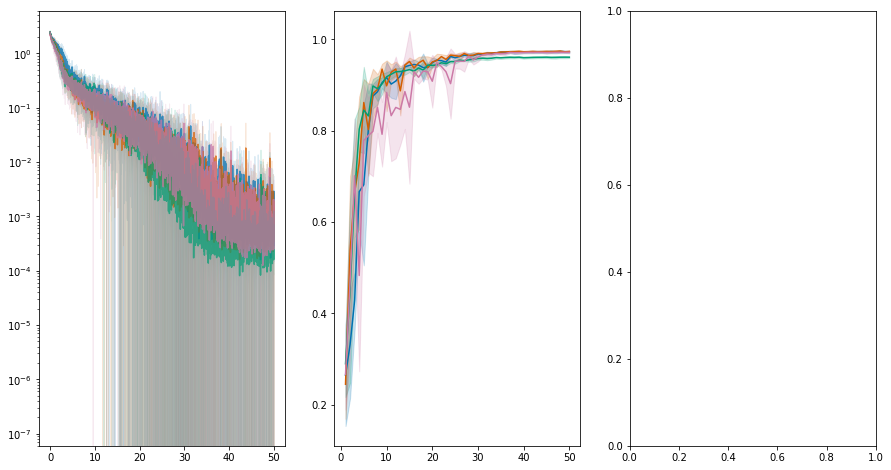

In [125]:
plotfolder("out/olympe/deanas_mnist_wlr0.005_alr0.005_2022-09-13.09:47:11")

Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=True)
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=False)


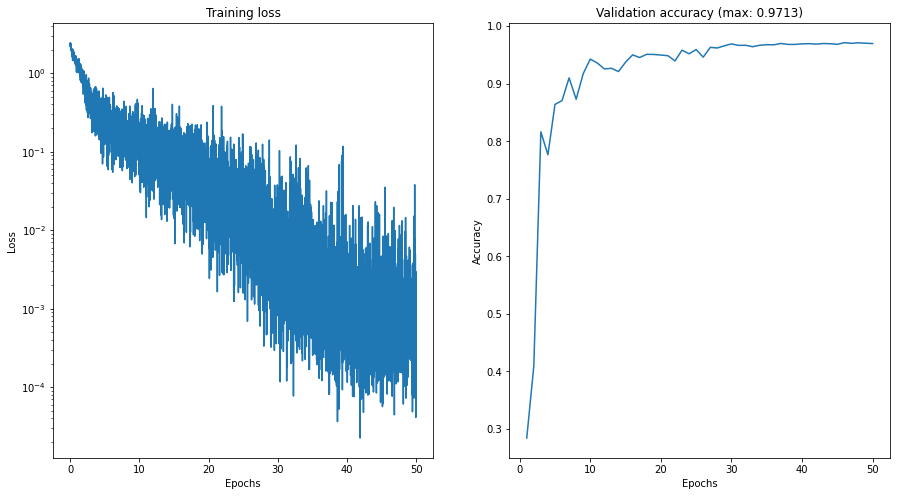

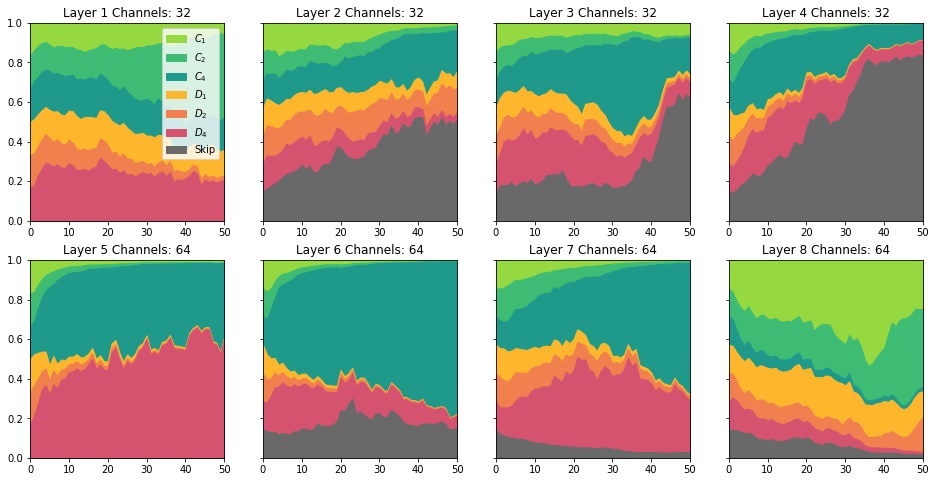

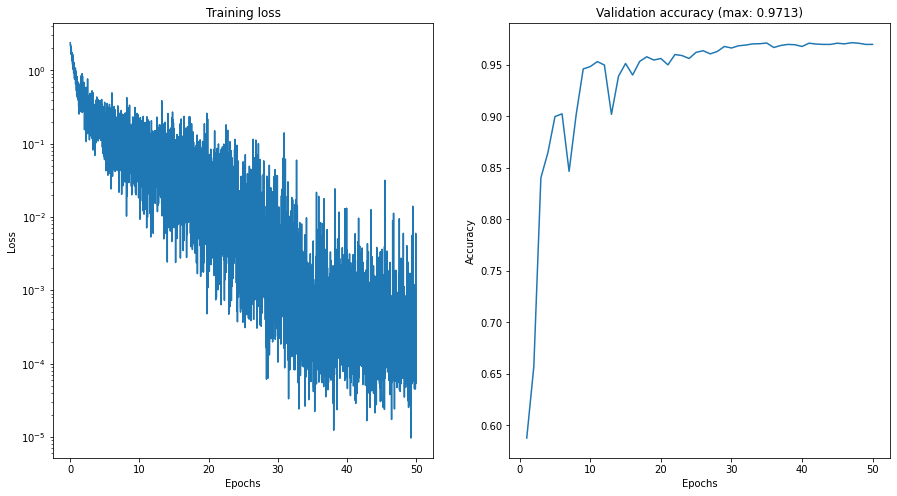

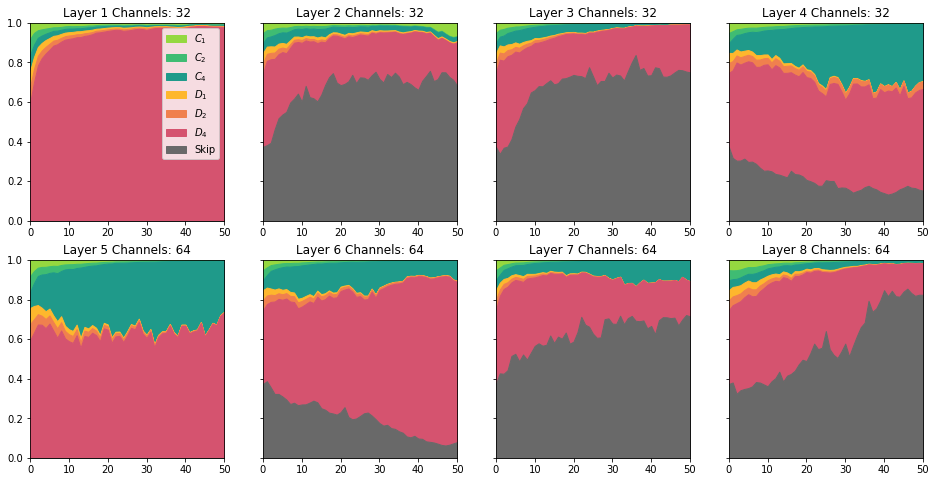

In [8]:
plotdea("out/olympe/logsdea_2022-08-11_14:41:53.pkl")
plotdea("out/olympe/logsdea_2022-08-11_14:42:15.pkl")


Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=True, task='mnist')
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=False, task='mnist')


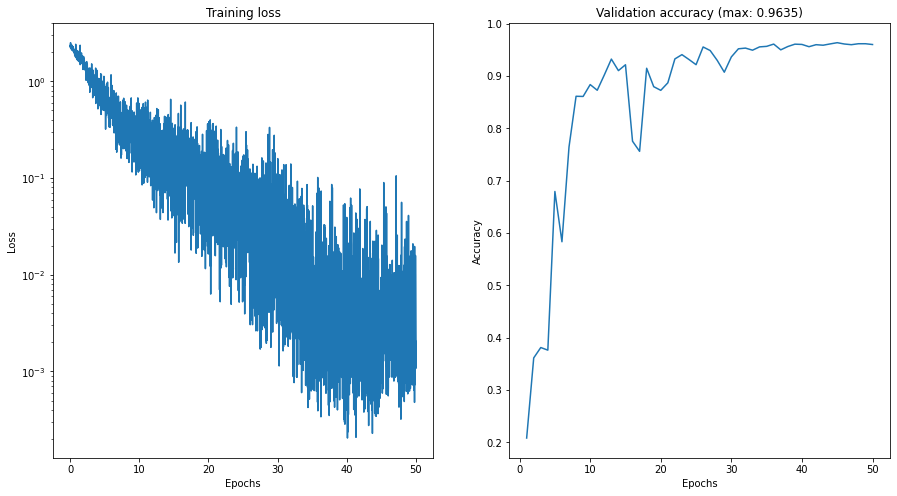

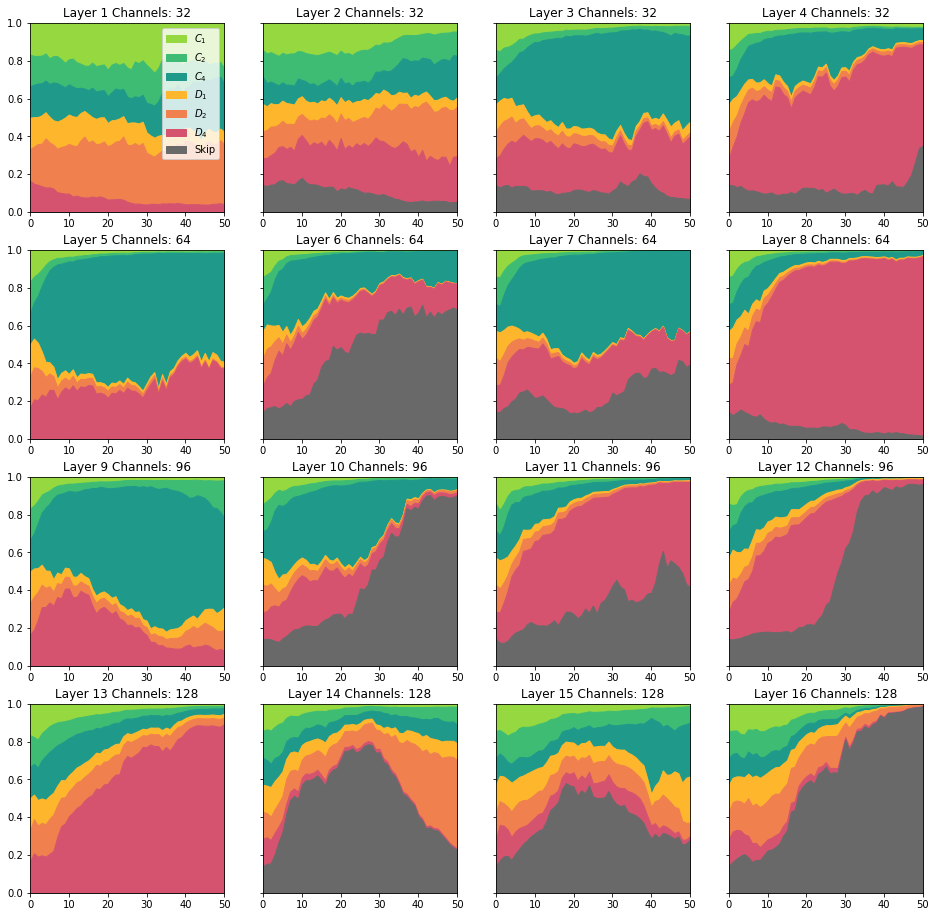

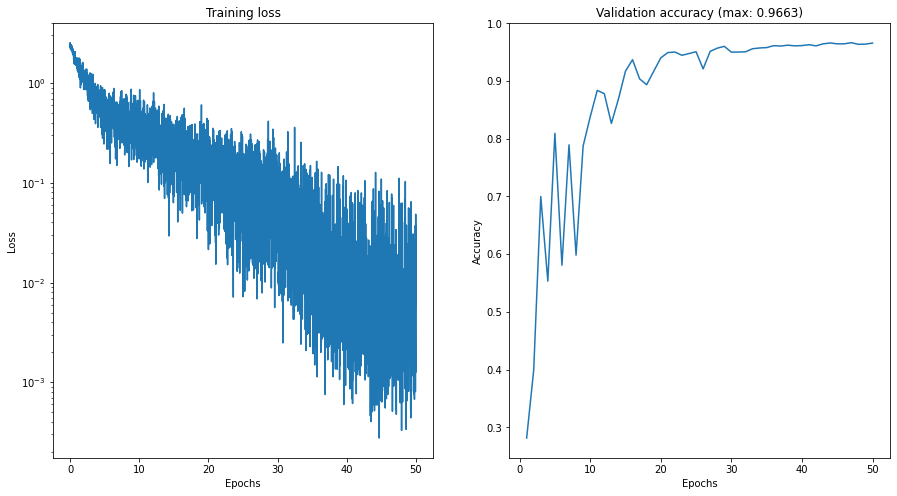

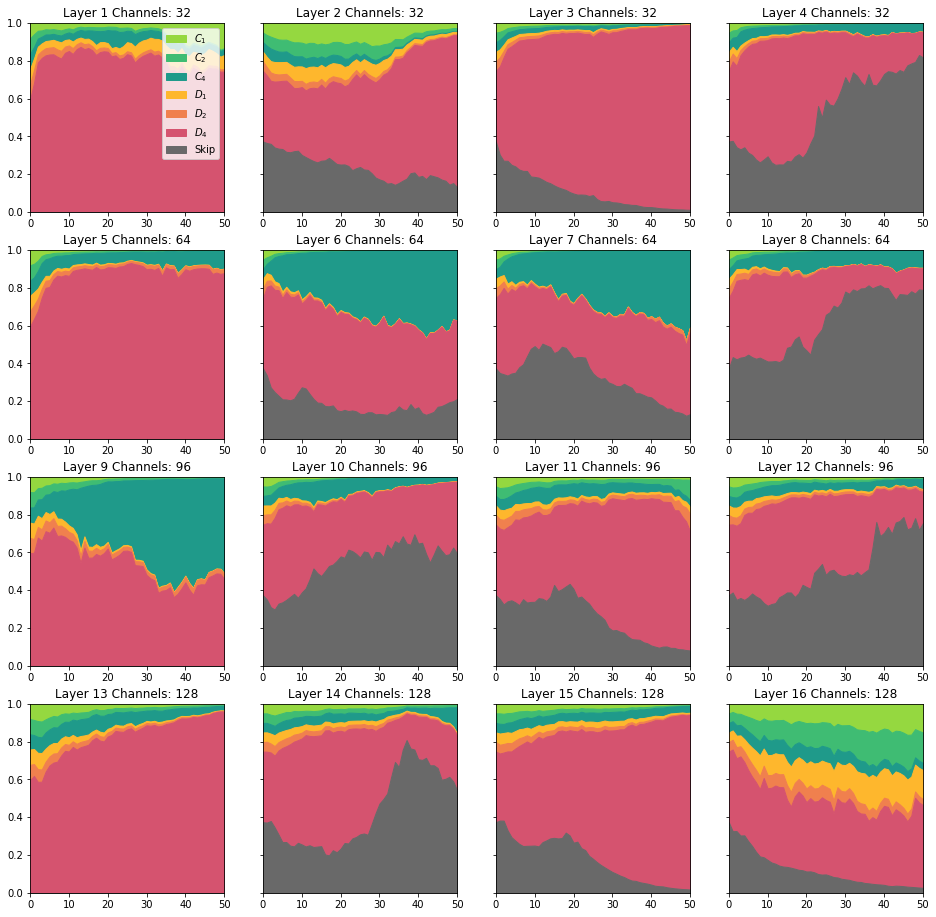

In [9]:
plotdea("out/olympe/logsdea_2022-08-11_17:21:27.pkl")
plotdea("out/olympe/logsdea_2022-08-11_17:21:31.pkl")

Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=False, task='mnist', seed=-1)
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=True, task='mnist', seed=-1)


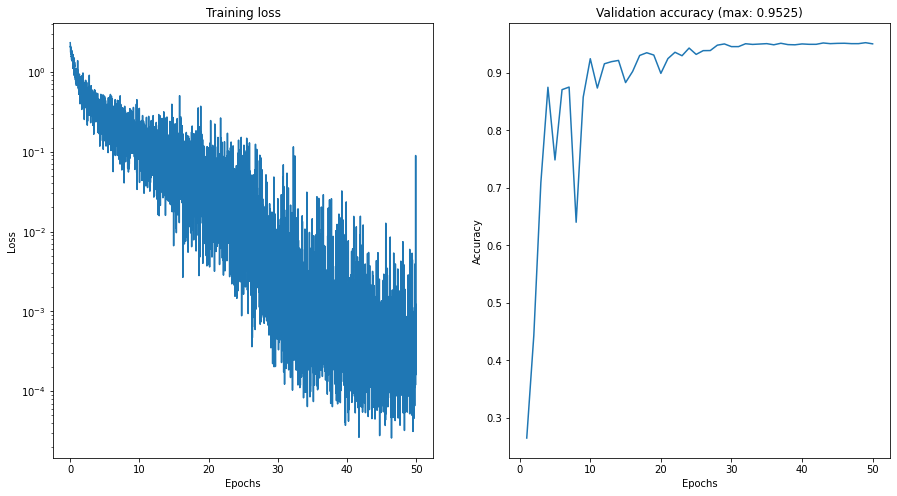

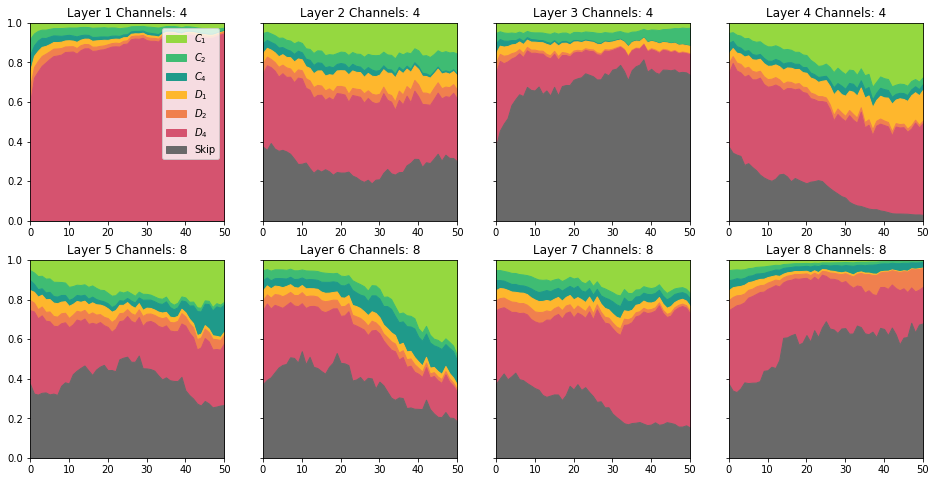

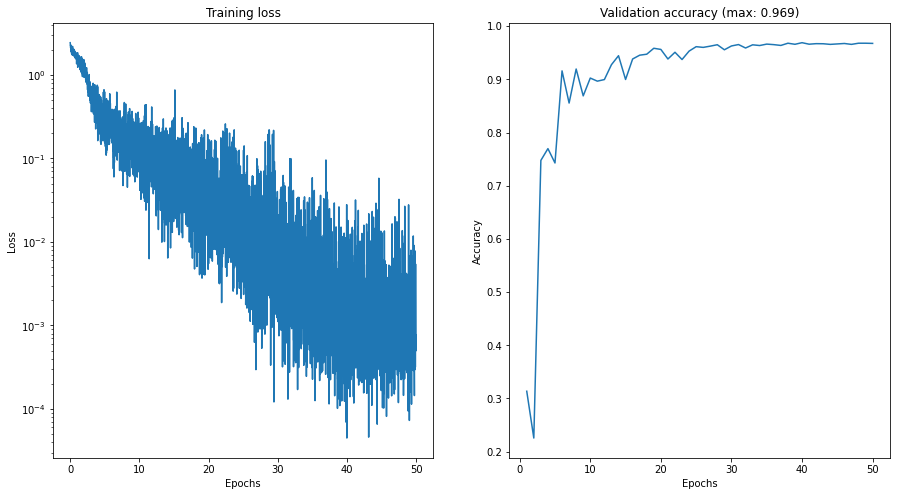

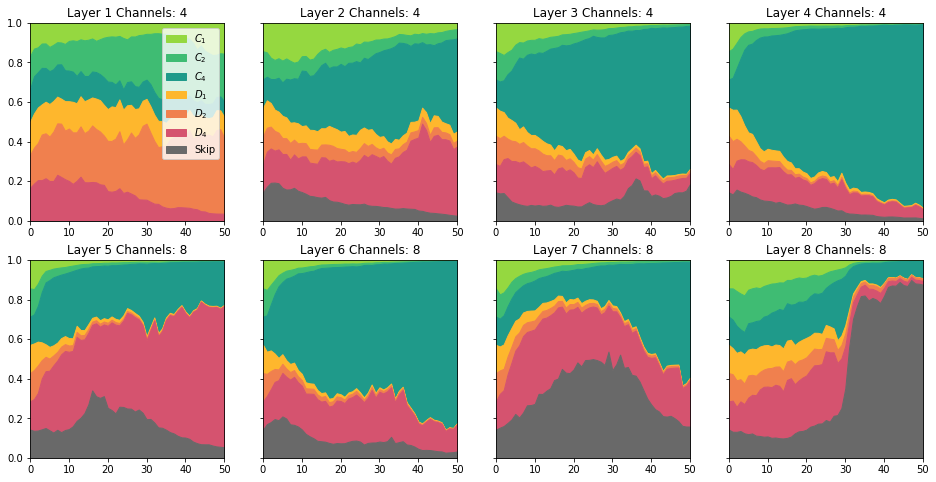

In [10]:
plotdea("out/olympe/logsdea_2022-08-12_13:58:46.pkl")
plotdea("out/olympe/logsdea_2022-08-12_13:59:00.pkl")

Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=True, task='mnist', seed=-1, d16=True)
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=False, task='mnist', seed=-1, d16=True)


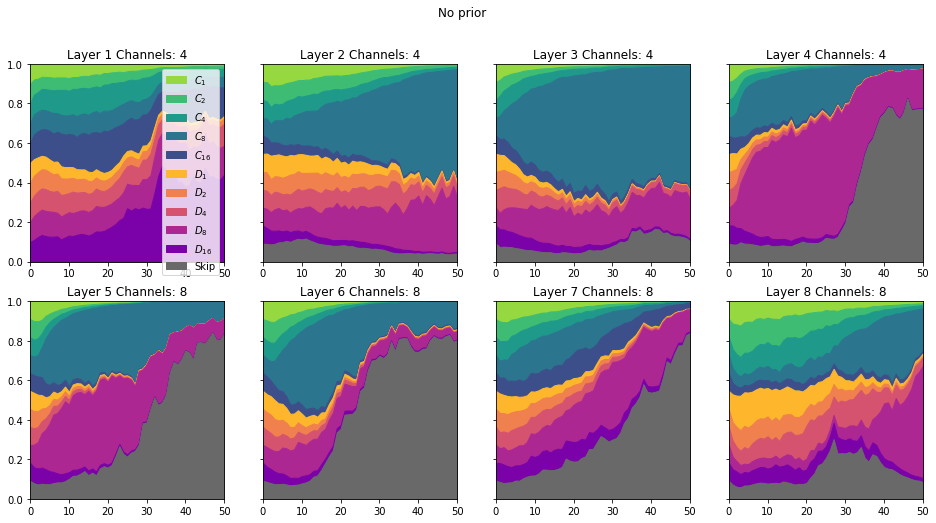

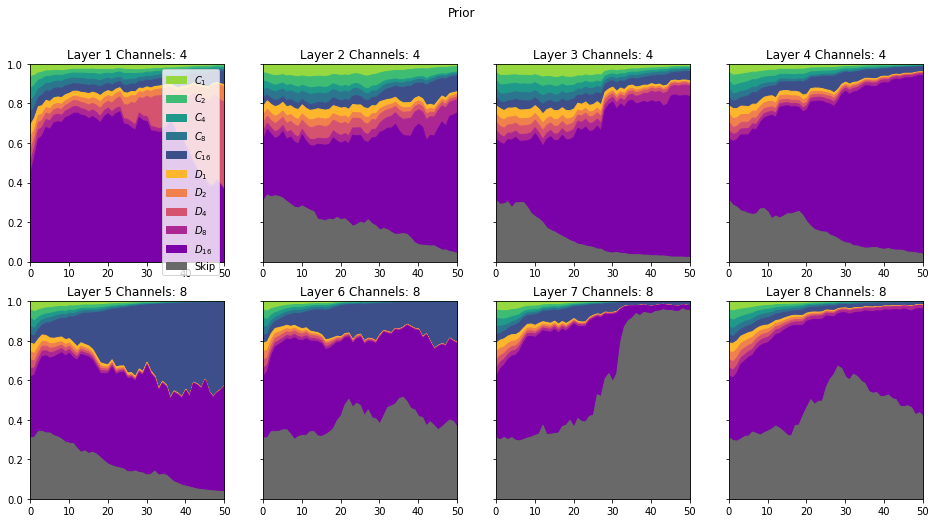

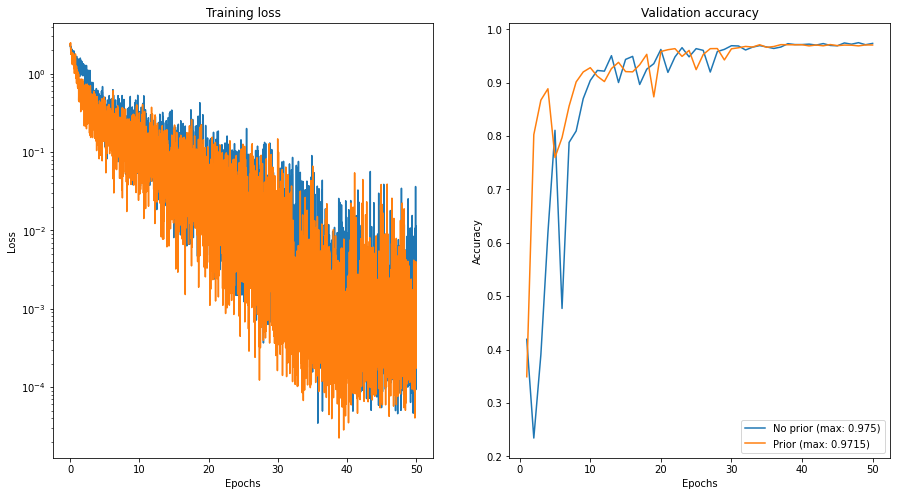

In [11]:
comparedea(["out/olympe/logsdea_2022-08-12_15:05:41.pkl", 
"out/olympe/logsdea_2022-08-12_15:15:13.pkl"], ["No prior", "Prior"])

Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=False, task='isic', seed=-1, d16=False)
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=False, task='galaxy10', seed=-1, d16=False)


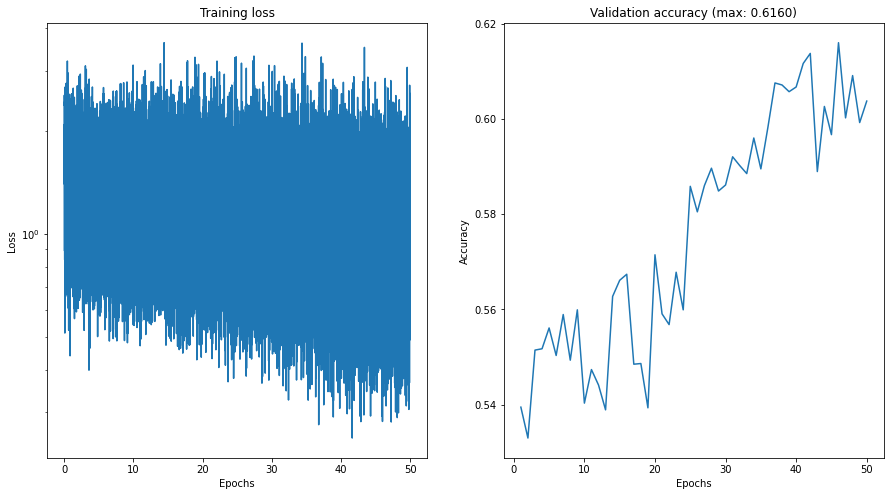

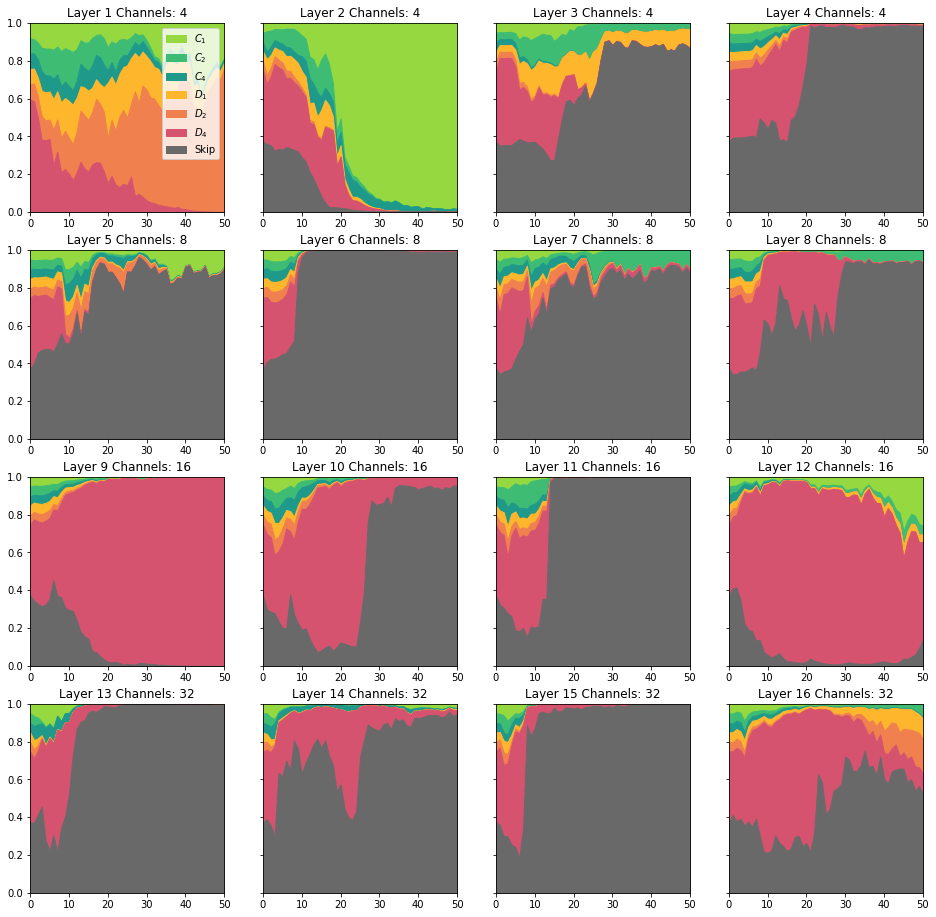

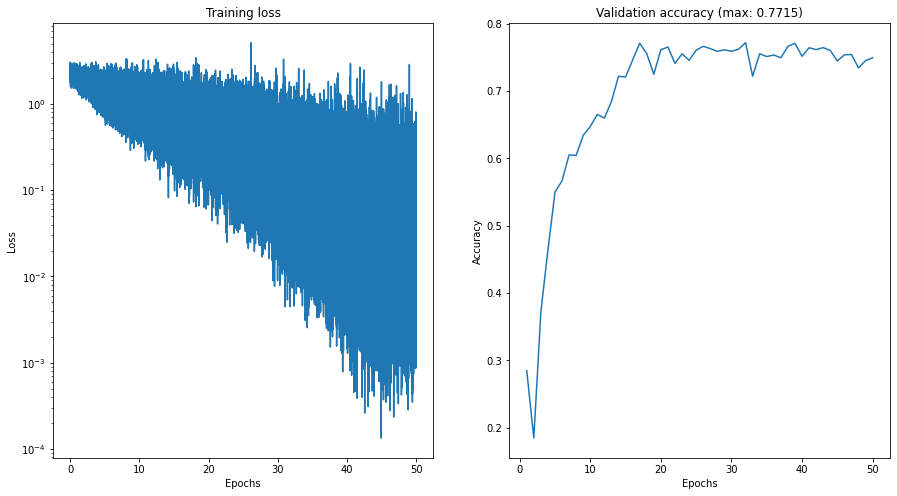

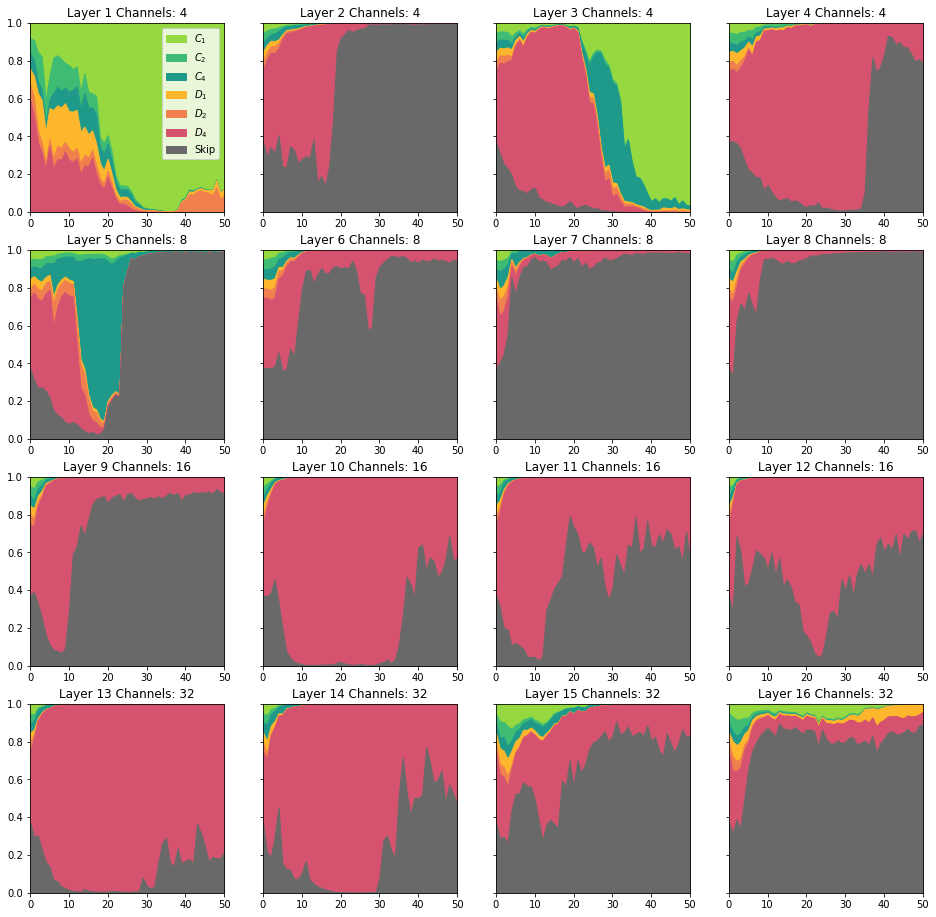

In [12]:
plotdea("out/olympe/logsdea_2022-08-17_11:43:54.pkl")
plotdea("out/olympe/logsdea_2022-08-17_16:08:18.pkl")

Namespace(epochs=50, weightlr=0.01, alphalr=0.001, path=PosixPath('/tmpdir/maile'), equalize=False, task='isic', seed=-1, d16=False)


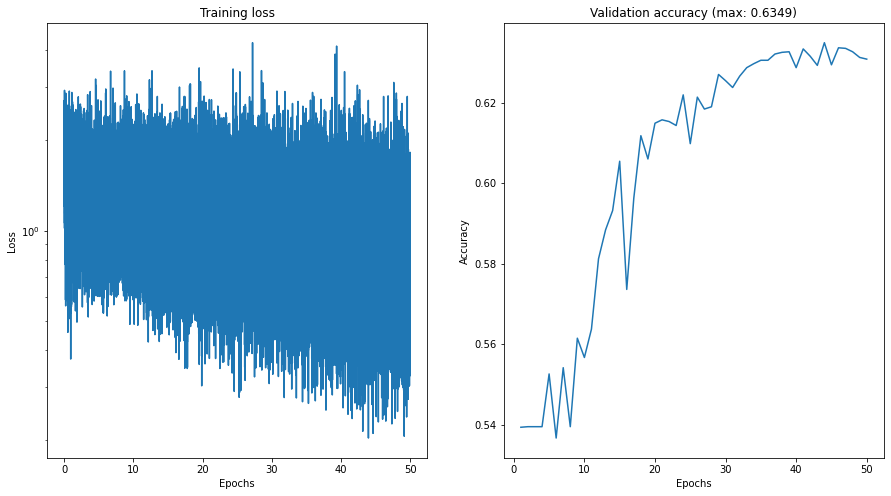

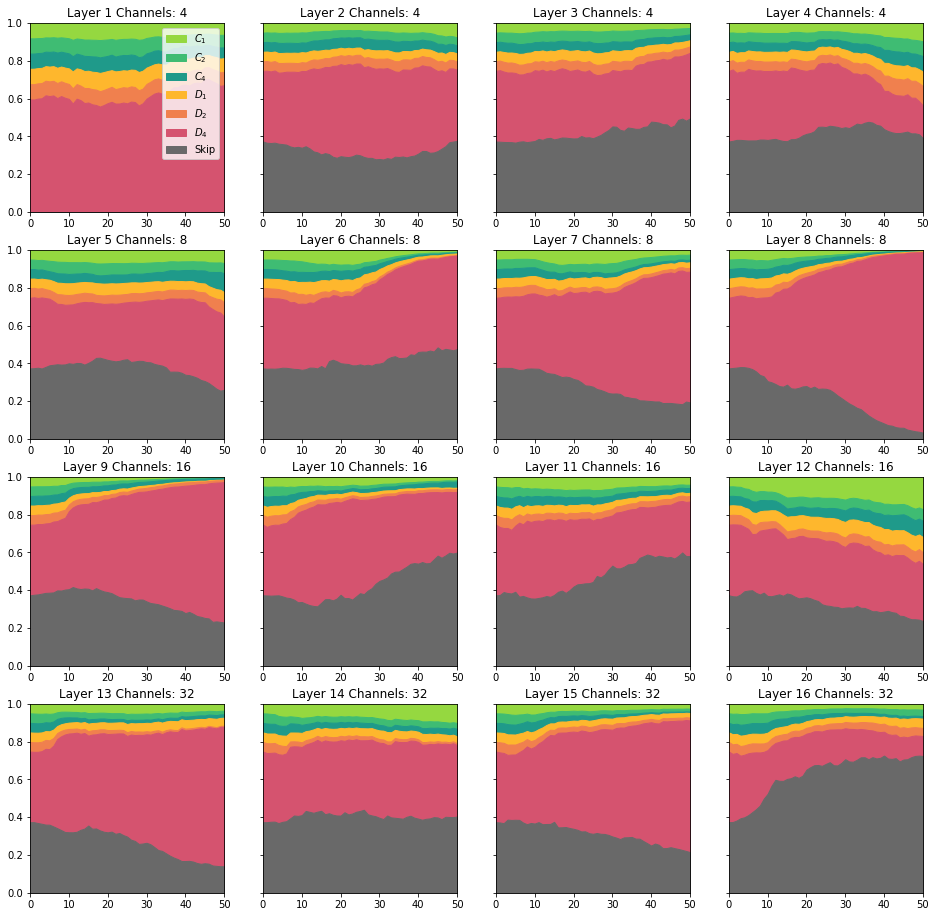

In [13]:
plotdea("out/olympe/logsdea_2022-08-22_16:14:01.pkl")

Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=False, task='mnist', seed=-1, d16=False, c4=True, indim=1, outdim=10, pools=4, kernel=5, stages=2, hidden=64)


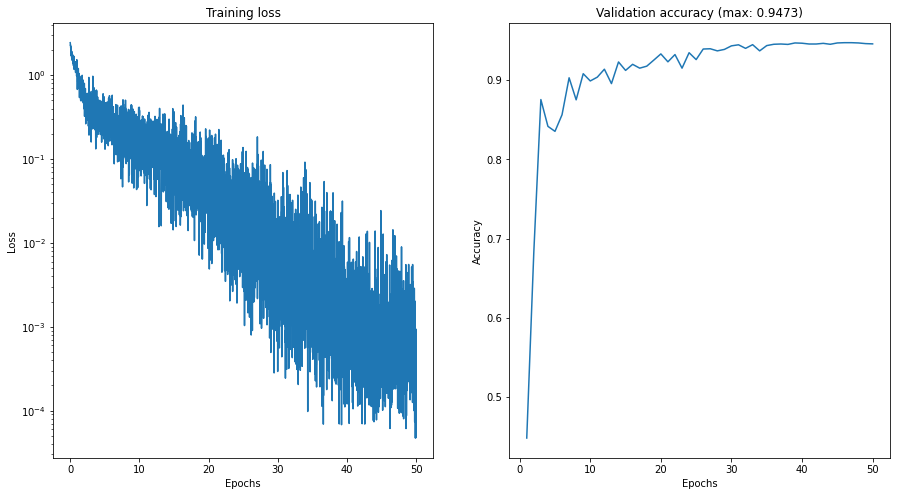

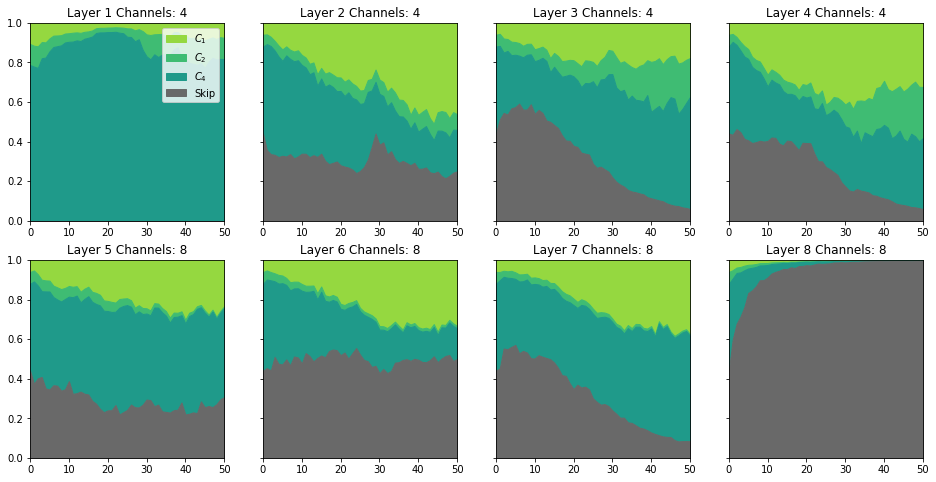

In [8]:
plotdea("out/olympe/logsdea_2022-09-06_12:56:17.pkl")

Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=False, task='mnist', seed=-1, d16=False, c4=True, indim=1, outdim=10, pools=4, kernel=5, stages=2, hidden=64)
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=True, task='mnist', seed=-1, d16=False, c4=True, indim=1, outdim=10, pools=4, kernel=5, stages=2, hidden=64)
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=False, baseline=True, task='mnist', seed=-1, d16=False, c4=False, indim=1, outdim=10, pools=4, kernel=5, stages=2, hidden=64)


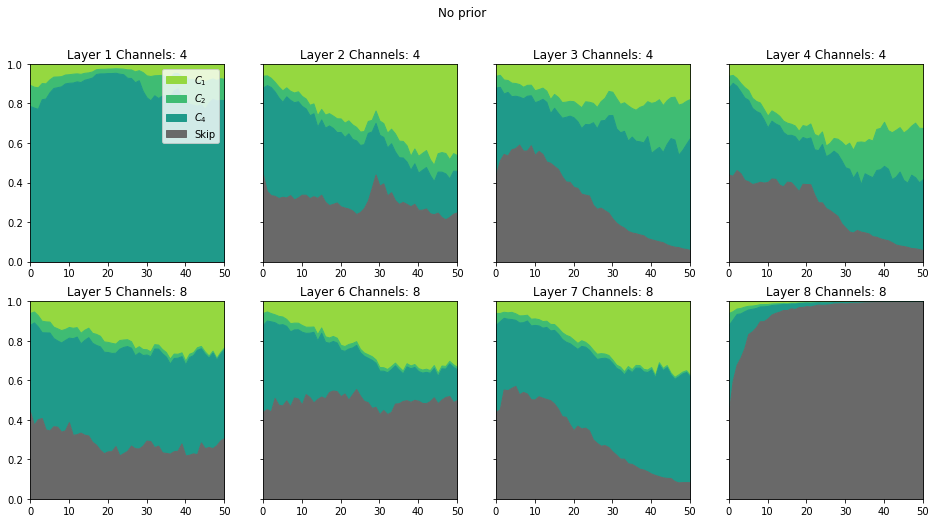

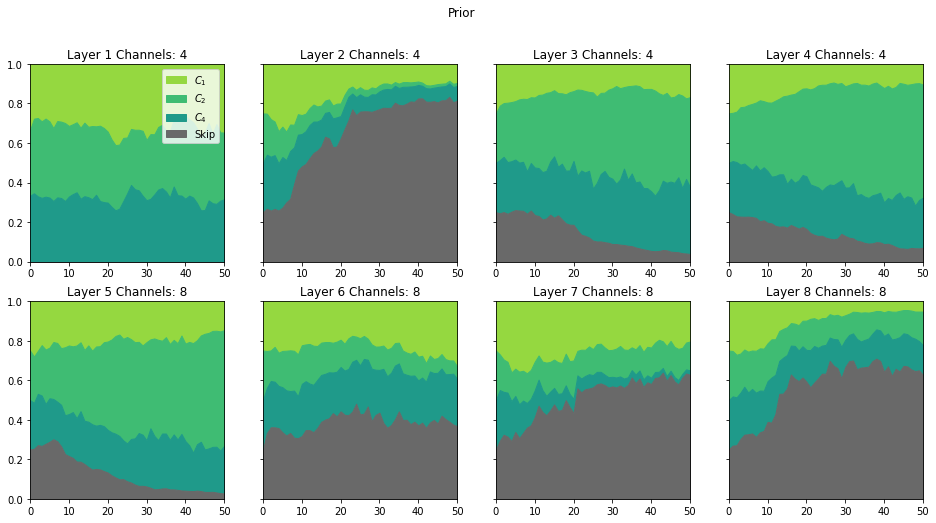

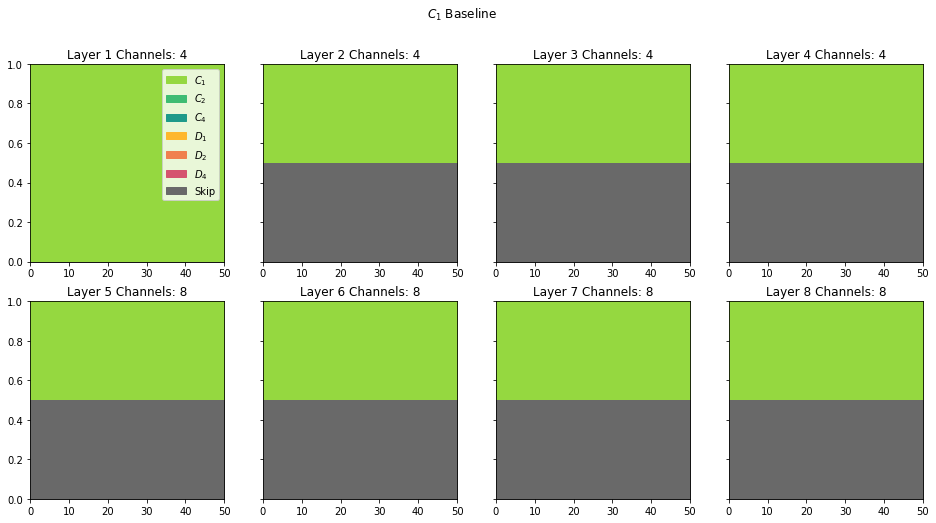

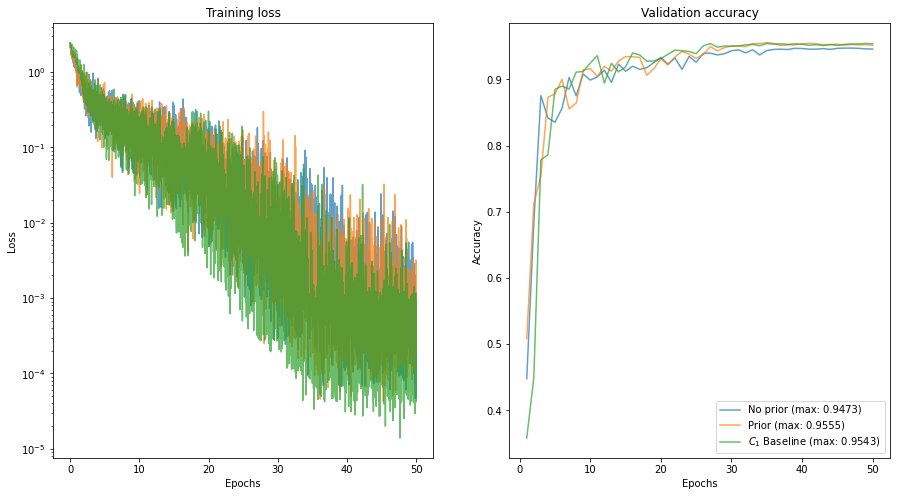

In [13]:
comparedea(["out/olympe/logsdea_2022-09-06_12:56:17.pkl", 
"out/olympe/logsdea_2022-09-06_13:31:10.pkl","out/olympe/logsdea_2022-09-06_13:45:19.pkl"], ["No prior", "Prior", "$C_1$ Baseline"])

Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=True, baseline=False, task='mnist', seed=-1, d16=False, c4=True, indim=1, outdim=10, pools=4, kernel=5, stages=2, hidden=64)


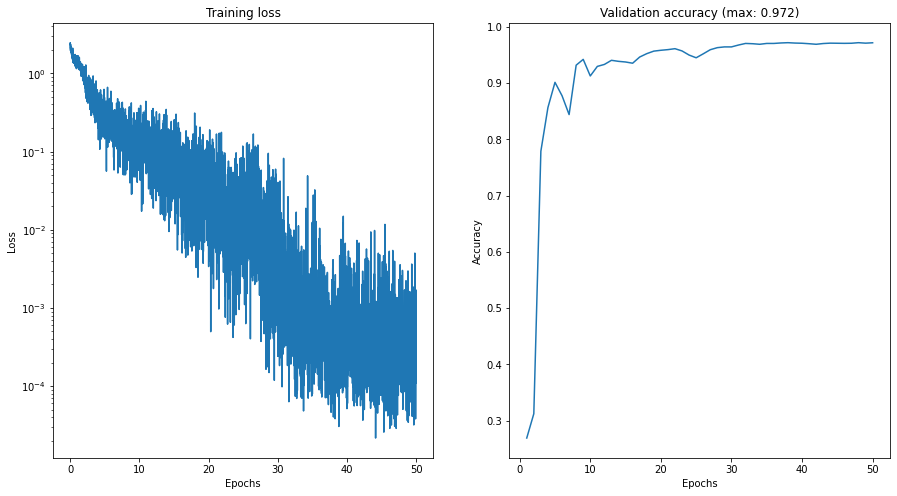

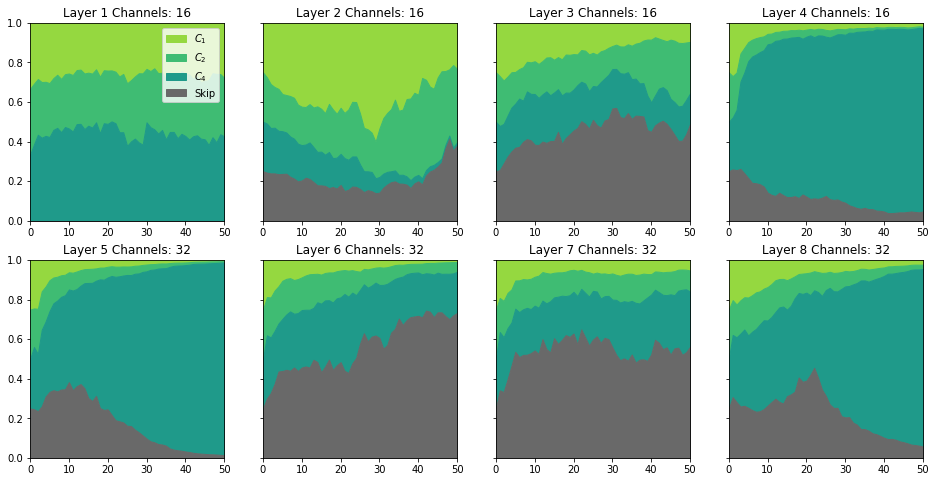

In [14]:
plotdea("out/olympe/logsdea_2022-09-06_15:52:35.pkl")

Namespace(epochs=50, weightlr=0.01, alphalr=0.01, hidden=64, basechannels=16, kernel=5, path=PosixPath('/tmpdir/maile'), equalize=True, baseline=True, task='mnist', seed=-1, batch_size=-1, d16=False, c4=True, tune=False, indim=1, outdim=10, pools=4, stages=2)
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, hidden=64, basechannels=16, kernel=5, path=PosixPath('/tmpdir/maile'), equalize=False, baseline=True, task='mnist', seed=-1, batch_size=-1, d16=False, c4=True, tune=False, indim=1, outdim=10, pools=4, stages=2)
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, hidden=64, basechannels=16, kernel=5, path=PosixPath('/tmpdir/maile'), equalize=True, baseline=False, task='mnist', seed=-1, batch_size=-1, d16=False, c4=True, tune=False, test=True, indim=1, outdim=10, pools=4, stages=2)
Test accuracy: 0.97156


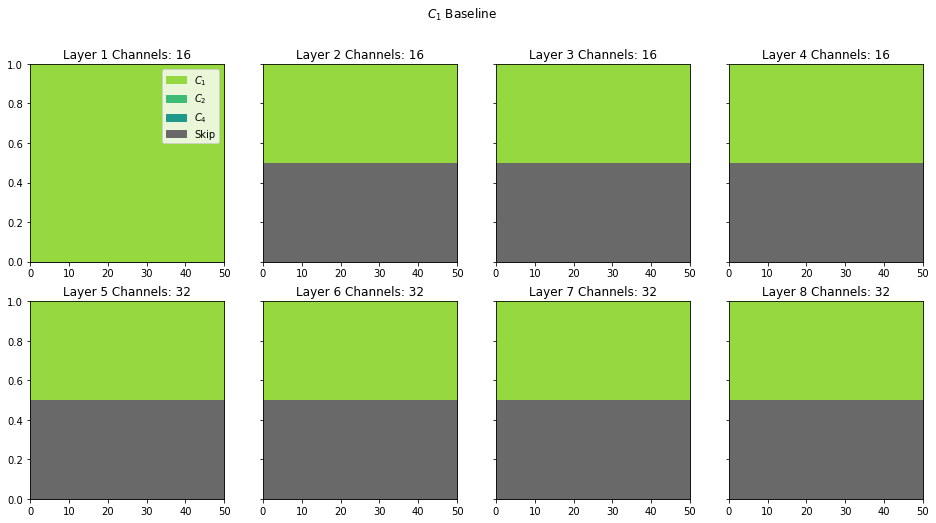

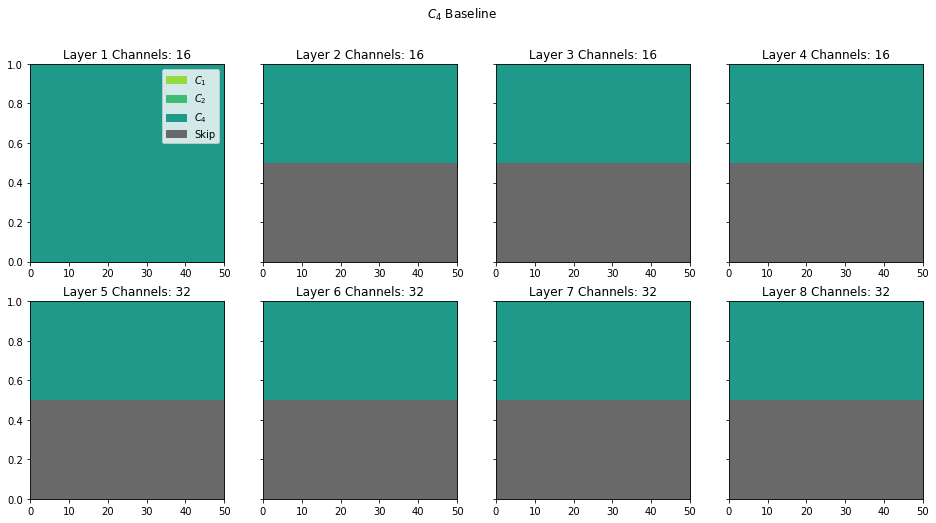

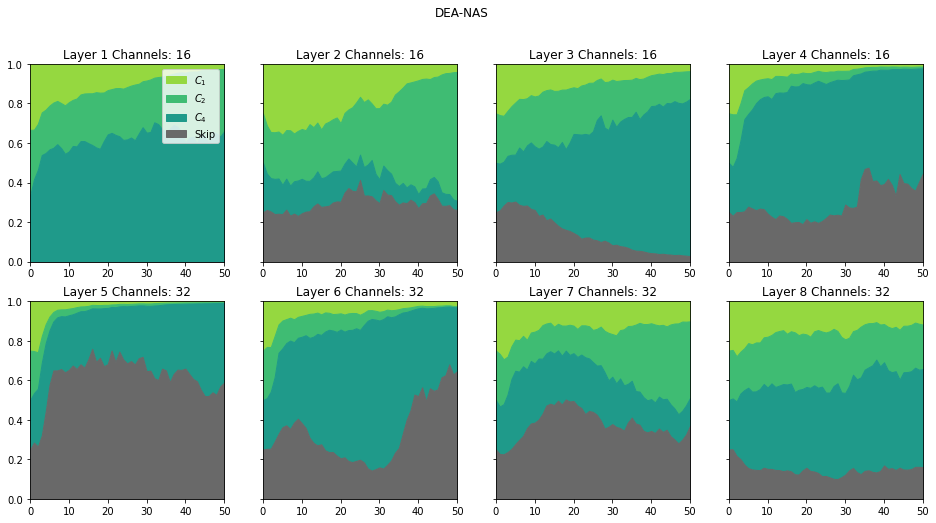

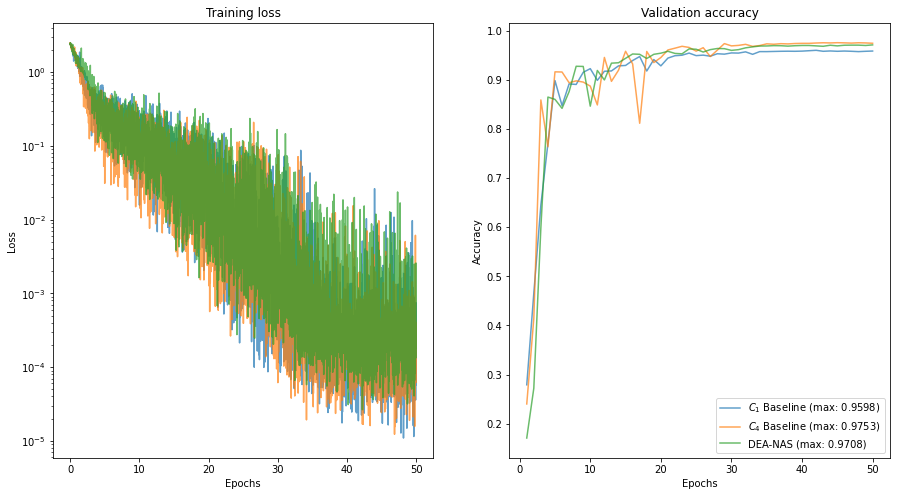

In [4]:
comparedea(["out/olympe/logsdea_2022-09-08_13:43:42.pkl", 
    "out/olympe/logsdea_2022-09-08_13:43:45.pkl",
    "out/olympe/logsdea_2022-09-08_15:32:38.pkl"], ["$C_1$ Baseline", 
    "$C_4$ Baseline", "DEA-NAS"])

Namespace(epochs=50, weightlr=0.01, alphalr=0.01, hidden=64, basechannels=16, kernel=5, path=PosixPath('/tmpdir/maile'), equalize=True, baseline=True, task='mnist', seed=-1, batch_size=-1, d16=False, c4=False, tune=False, test=False, indim=1, outdim=10, pools=4, stages=2)
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, hidden=64, basechannels=16, kernel=5, path=PosixPath('/tmpdir/maile'), equalize=False, baseline=True, task='mnist', seed=-1, batch_size=-1, d16=False, c4=False, tune=False, test=False, indim=1, outdim=10, pools=4, stages=2)
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, hidden=64, basechannels=16, kernel=5, path=PosixPath('/tmpdir/maile'), equalize=False, baseline=False, task='mnist', seed=-1, batch_size=-1, d16=False, c4=False, tune=False, test=False, indim=1, outdim=10, pools=4, stages=2)


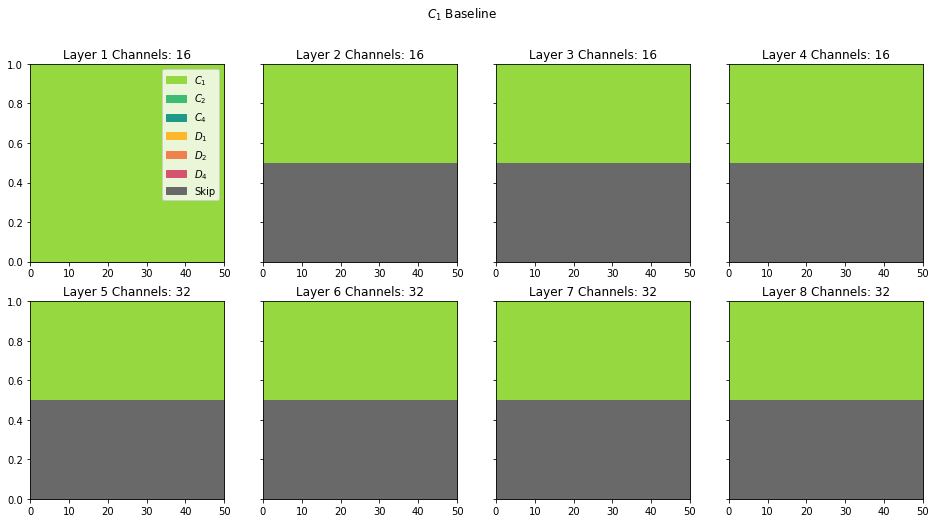

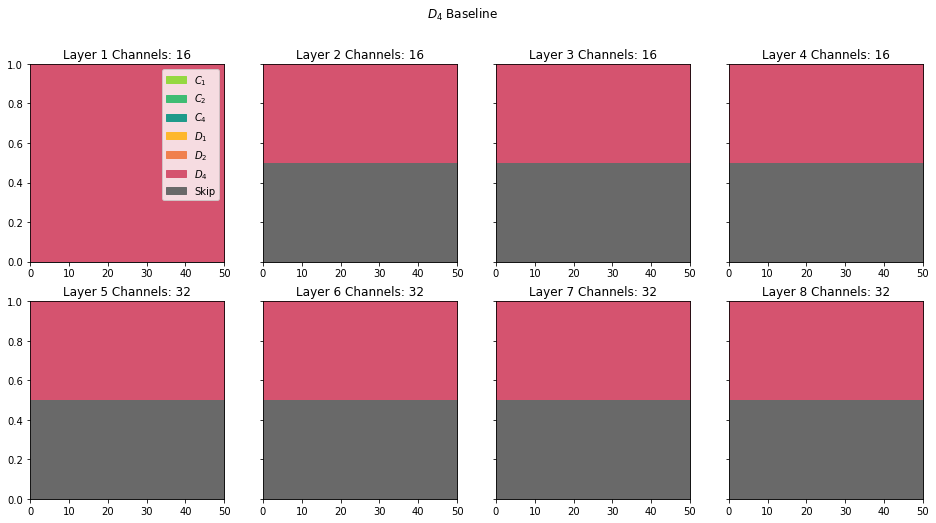

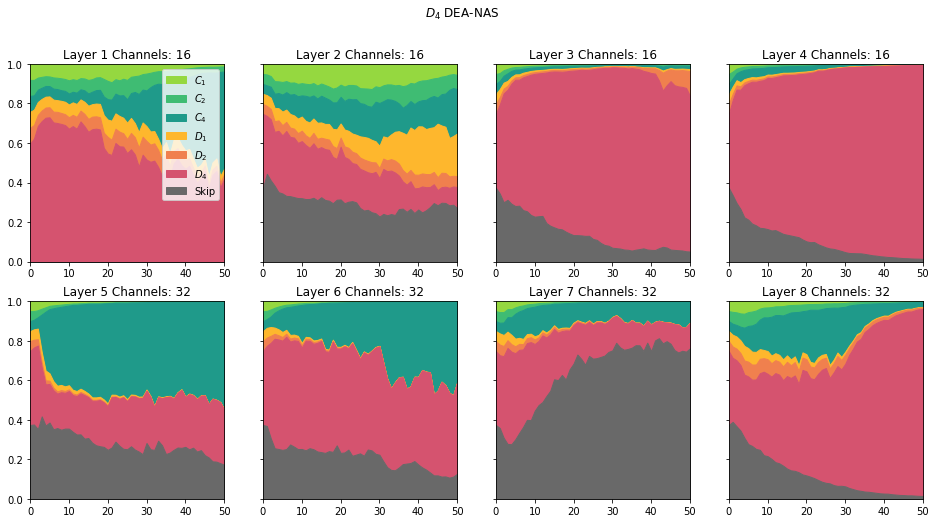

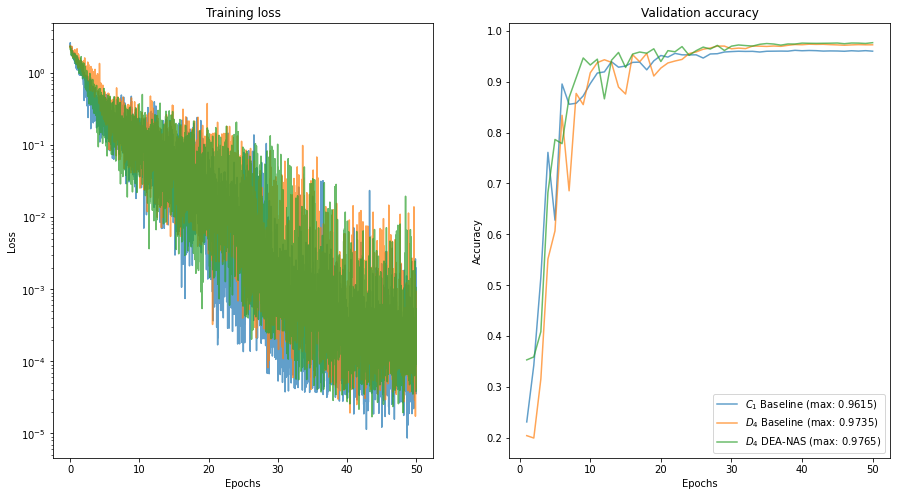

In [19]:
comparedea(["out/olympe/logsdea_2022-09-09_15:52:12.pkl",
            "out/olympe/logsdea_2022-09-09_16:02:08.pkl",
            "out/olympe/logsdea_2022-09-09_15:50:19.pkl"],
            ["$C_1$ Baseline", "$D_4$ Baseline", "$D_4$ DEA-NAS"])

Namespace(epochs=50, weightlr=0.01, alphalr=0.01, hidden=64, basechannels=16, kernel=5, path=PosixPath('/tmpdir/maile'), equalize=True, baseline=True, task='mnist', seed=-1, batch_size=-1, d16=False, c4=False, tune=False, test=False, indim=1, outdim=10, pools=4, stages=2)
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, hidden=64, basechannels=16, kernel=5, path=PosixPath('/tmpdir/maile'), equalize=False, baseline=True, task='mnist', seed=-1, batch_size=-1, d16=False, c4=False, tune=False, test=False, indim=1, outdim=10, pools=4, stages=2)
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, hidden=64, basechannels=16, kernel=5, path=PosixPath('/tmpdir/maile'), equalize=False, baseline=False, task='mnist', seed=-1, batch_size=-1, d16=False, c4=False, tune=False, test=False, indim=1, outdim=10, pools=4, stages=2)


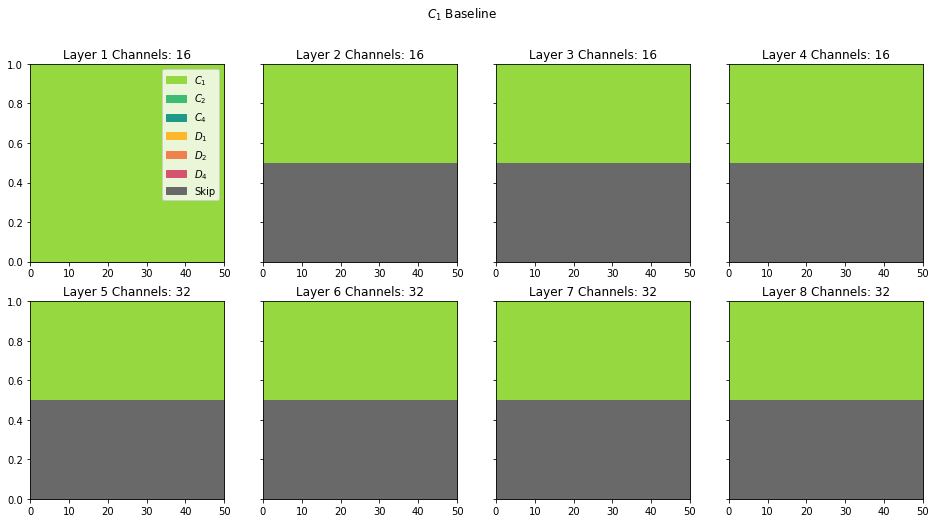

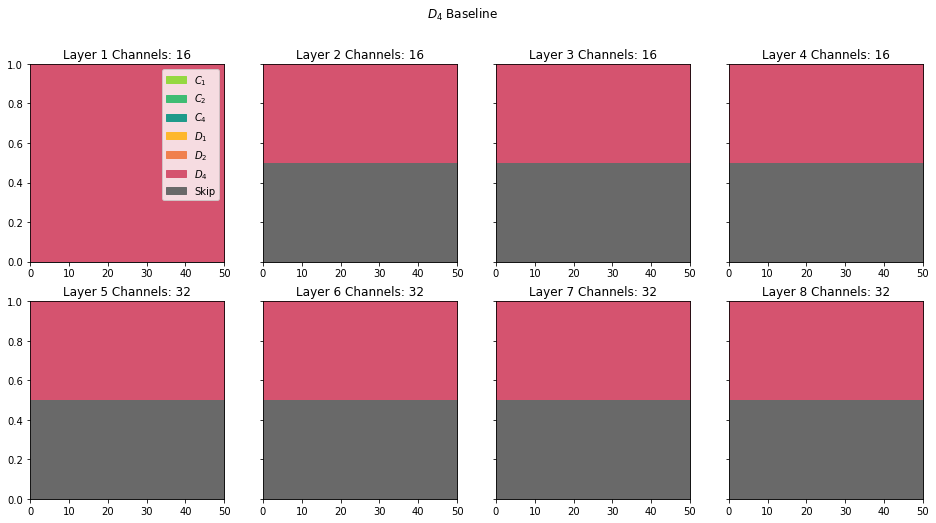

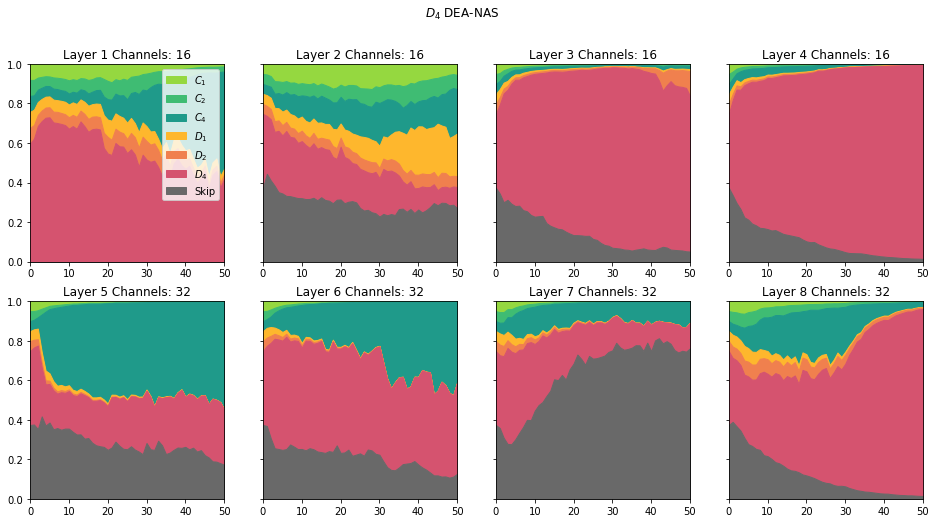

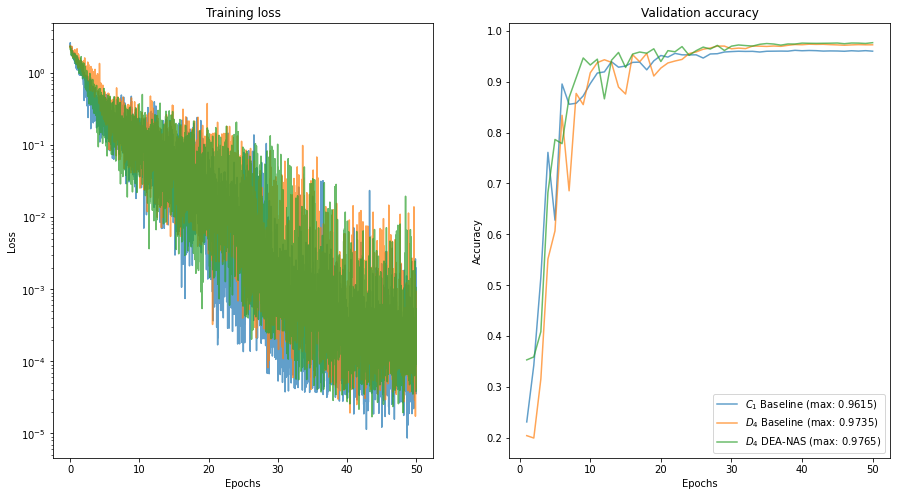

In [19]:
comparedea(["out/olympe/logsdea_2022-09-09_15:52:12.pkl",
            "out/olympe/logsdea_2022-09-09_16:02:08.pkl",
            "out/olympe/logsdea_2022-09-09_15:50:19.pkl"],
            ["$C_1$ Baseline", "$D_4$ Baseline", "$D_4$ DEA-NAS"])

FileNotFoundError: [Errno 2] No such file or directory: 'out/olympe/deanas_mnist_wlr0.001_alr0.005_2022-09-12.12:56:02logsdea_blD4_2022-09-12_12:56:06.pkl'